<a href="https://colab.research.google.com/github/casjunior93/DIO-Treinamento-de-Redes-Neurais-com-Transfer-Learning/blob/master/Desafio_DIO_Transfer%C3%AAncia_de_aprendizado.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importando bibliotecas fundamentais

In [15]:
%matplotlib inline

import os

#if using Theano with GPU
#os.environ["KERAS_BACKEND"] = "tensorflow"

import random
import numpy as np
import keras

import zipfile

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

#from keras.preprocessing import image
from tensorflow.keras.utils import load_img, img_to_array
from keras.applications.imagenet_utils import preprocess_input
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Model

# Obtendo o dataset de cães e gatos (upload feito previamente no Google Drive)

In [8]:
%%time
#Autorizando o acesso ao Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
CPU times: user 37.7 ms, sys: 6.52 ms, total: 44.2 ms
Wall time: 2.26 s


In [23]:
%%time
local_zip = '/content/drive/MyDrive/ANÁLISES DE DADOS/kagglecatsanddogs_5340.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

CPU times: user 9.92 s, sys: 5.37 s, total: 15.3 s
Wall time: 17.7 s


In [24]:
%%time
root = '/tmp/PetImages'
train_split, val_split = 0.7, 0.15

CPU times: user 4 µs, sys: 2 µs, total: 6 µs
Wall time: 11.9 µs


In [25]:
%%time
categories = [x[0] for x in os.walk(root) if x[0]][1:]
print(categories)

['/tmp/PetImages/Cat', '/tmp/PetImages/Dog']
CPU times: user 20.3 ms, sys: 12 ms, total: 32.3 ms
Wall time: 42.6 ms


Esta função é útil para pré-processar os dados em um vetor de imagem e entrada.

In [26]:
def get_image(path):
    img = load_img(path, target_size=(224, 224))
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return img, x

Carrega as imagens da pasta raiz:

In [34]:
%%time
data = []
for c, category in enumerate(categories):
    num_amostra = 0;
    images = [os.path.join(dp, f) for dp, dn, filenames 
              in os.walk(category) for f in filenames 
              if os.path.splitext(f)[1].lower() in ['.jpg','.png','.jpeg']]
    for img_path in images:
        if num_amostra < 1000:
          print(img_path, num_amostra)
          img, x = get_image(img_path)
          data.append({'x':np.array(x[0]), 'y':c})
        num_amostra = num_amostra + 1

# conta o numero de classes
num_classes = len(categories)

/tmp/PetImages/Cat/12298.jpg 0
/tmp/PetImages/Cat/2815.jpg 1
/tmp/PetImages/Cat/8254.jpg 2
/tmp/PetImages/Cat/11254.jpg 3
/tmp/PetImages/Cat/5229.jpg 4
/tmp/PetImages/Cat/6509.jpg 5
/tmp/PetImages/Cat/2668.jpg 6
/tmp/PetImages/Cat/10003.jpg 7
/tmp/PetImages/Cat/10481.jpg 8
/tmp/PetImages/Cat/1143.jpg 9
/tmp/PetImages/Cat/10310.jpg 10
/tmp/PetImages/Cat/11805.jpg 11
/tmp/PetImages/Cat/7369.jpg 12
/tmp/PetImages/Cat/5531.jpg 13
/tmp/PetImages/Cat/410.jpg 14
/tmp/PetImages/Cat/6680.jpg 15
/tmp/PetImages/Cat/724.jpg 16
/tmp/PetImages/Cat/1515.jpg 17
/tmp/PetImages/Cat/2723.jpg 18
/tmp/PetImages/Cat/3528.jpg 19
/tmp/PetImages/Cat/1360.jpg 20
/tmp/PetImages/Cat/488.jpg 21
/tmp/PetImages/Cat/11152.jpg 22
/tmp/PetImages/Cat/6418.jpg 23
/tmp/PetImages/Cat/11732.jpg 24
/tmp/PetImages/Cat/2577.jpg 25
/tmp/PetImages/Cat/10241.jpg 26
/tmp/PetImages/Cat/3976.jpg 27
/tmp/PetImages/Cat/3353.jpg 28
/tmp/PetImages/Cat/8720.jpg 29
/tmp/PetImages/Cat/10262.jpg 30
/tmp/PetImages/Cat/1842.jpg 31
/tmp/PetIma

In [36]:
%%time
random.shuffle(data)

CPU times: user 2.84 ms, sys: 0 ns, total: 2.84 ms
Wall time: 3.1 ms


In [37]:
%%time
idx_val = int(train_split * len(data))
idx_test = int((train_split + val_split) * len(data))
train = data[:idx_val]
val = data[idx_val:idx_test]
test = data[idx_test:]

CPU times: user 44 µs, sys: 26 µs, total: 70 µs
Wall time: 77 µs


In [43]:
%%time
x_train, y_train = np.array([t["x"] for t in train]), [t["y"] for t in train]
x_val, y_val = np.array([t["x"] for t in val]), [t["y"] for t in val]
x_test, y_test = np.array([t["x"] for t in test]), [t["y"] for t in test]
print(y_test)

[1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1]
CPU times: user 453 ms, sys: 7.77 ms, total: 461 ms
Wall time: 470 ms


In [44]:
# normalizando os dados, 
x_train = x_train.astype('float32') / 255.
x_val = x_val.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# convert labels to one-hot vectors
y_train = keras.utils.to_categorical(y_train, num_classes)
y_val = keras.utils.to_categorical(y_val, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
print(y_test.shape)

(300, 2)


In [45]:
# summary
print("finished loading %d images from %d categories"%(len(data), num_classes))
print("train / validation / test split: %d, %d, %d"%(len(x_train), len(x_val), len(x_test)))
print("training data shape: ", x_train.shape)
print("training labels shape: ", y_train.shape)

finished loading 2000 images from 2 categories
train / validation / test split: 1400, 300, 300
training data shape:  (1400, 224, 224, 3)
training labels shape:  (1400, 2)


CPU times: user 146 ms, sys: 11.4 ms, total: 158 ms
Wall time: 162 ms


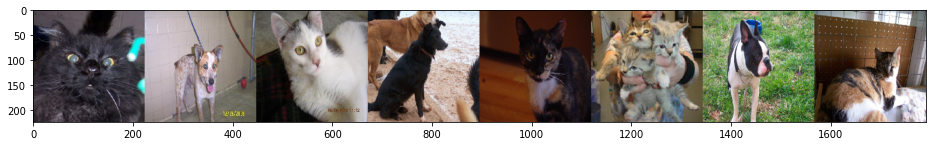

In [49]:
%%time
images = [os.path.join(dp, f) for dp, dn, filenames in os.walk(root) for f in filenames if os.path.splitext(f)[1].lower() in ['.jpg','.png','.jpeg']]
idx = [int(len(images) * random.random()) for i in range(8)]
imgs = [load_img(images[i], target_size=(224, 224)) for i in idx]
concat_image = np.concatenate([np.asarray(img) for img in imgs], axis=1)
plt.figure(figsize=(16,4))
plt.imshow(concat_image)

# Transferência de aprendizado a partir de uma rede existente

Carregar o VGG16 a partir do Keras, que foi treinada usando imagens do ImageNet e que tem os pesos disponíveis para download.

In [52]:
%%time
vgg = keras.applications.VGG16(weights='imagenet', include_top=True)
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [53]:
%%time
# referência à camada de entrada da VGG
inp = vgg.input

# faz uma nova camada softmax com num_classes neurônios 
new_classification_layer = Dense(num_classes, activation='softmax')

# conecta nossa nova camada à penúltima camada em VGG, e faz uma referência a ela
out = new_classification_layer(vgg.layers[-2].output)

# cria uma nova rede entre inp e out
model_new = Model(inp, out)

# congela todas as camadas para não serem treinadas, exceto a última
for l, layer in enumerate(model_new.layers[:-1]):
    layer.trainable = False

# garante que a última camada seja treinada
for l, layer in enumerate(model_new.layers[-1:]):
    layer.trainable = True

model_new.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model_new.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [ ]:
%%time
history2 = model_new.fit(x_train, y_train, 
                         batch_size=128, 
                         epochs=10, 
                         validation_data=(x_val, y_val))

Epoch 1/10
11/11 [==============================] - 957s 88s/step - loss: 0.8432 - accuracy: 0.5364 - val_loss: 0.5521 - val_accuracy: 0.7900
Epoch 2/10
 7/11 [==================>...........] - ETA: 4:32 - loss: 0.5556 - accuracy: 0.7176

Curvas de perdas e acurácia



In [ ]:
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(121)
ax.plot(history2.history["val_loss"])
ax.set_title("validation loss")
ax.set_xlabel("epochs")

ax2 = fig.add_subplot(122)
ax2.plot(history2.history["val_acc"])
ax2.set_title("validation accuracy")
ax2.set_xlabel("epochs")
ax2.set_ylim(0, 1)

plt.show()

Validação final do dataset de teste:

In [ ]:
loss, accuracy = model_new.evaluate(x_test, y_test, verbose=0)

print('Test loss:', loss)
print('Test accuracy:', accuracy)